# PyTorch 2 - A Short Introduction

In [1]:
import torch
print(torch.__version__)

2.6.0+cu124


## Quick Code Examples

### Before PyTorch 2.0

In [2]:
import torch
import torchvision

model = torchvision.models.resnet50()

### After PyTorch 2.0

In [3]:
import torch
import torchvision

model = torchvision.models.resnet50()
compiled_model = torch.compile(model)

## 0. Getting Setup

In [4]:
import torch

# Check PyTorch version
pt_version = torch.__version__
print(f"[INFO] Current PyTorch version: {pt_version} (should be 2.x+)")

# Install PyTorch 2.0 if necessary
if pt_version.split(".")[0] == "1": # Check if PyTorch version begins with 1
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    print("[INFO] PyTorch 2.x installed, if you're on Google Colab, you may need to restart your runtime.\
          Though as of April 2023, Google Colab comes with PyTorch 2.0 pre-installed.")
    import torch
    pt_version = torch.__version__
    print(f"[INFO] Current PyTorch version: {pt_version} (should be 2.x+)")
else:
    print("[INFO] PyTorch 2.x installed, you'll be able to use the new features.")

[INFO] Current PyTorch version: 2.6.0+cu124 (should be 2.x+)
[INFO] PyTorch 2.x installed, you'll be able to use the new features.


In [5]:
import torch.multiprocessing as mp
mp.set_start_method('spawn', force=True)

## 1. Get GPU Info

Why? PyTorch 2.0 features work best on newer NVIDIA GPUs.

What's that? To check, look into NVIDIA GPU compute compability scores. A score of 8.0+ should leverage **most** of the new PyTorch 2.0 features.

In [6]:
# Make sure we're using a NVIDIA GPU
if torch.cuda.is_available():
  gpu_info = !nvidia-smi
  gpu_info = '\n'.join(gpu_info)
  if gpu_info.find("failed") >= 0:
    print("Not connected to a GPU, to leverage the best of PyTorch 2.0, you should connect to a GPU.")

  # Get GPU name
  gpu_name = !nvidia-smi --query-gpu=gpu_name --format=csv
  gpu_name = gpu_name[1]
  GPU_NAME = gpu_name.replace(" ", "_") # remove underscores for easier saving
  print(f'GPU name: {GPU_NAME}')

  # Get GPU capability score
  GPU_SCORE = torch.cuda.get_device_capability()
  print(f"GPU capability score: {GPU_SCORE}")
  if GPU_SCORE >= (8, 0):
    print(f"GPU score higher than or equal to (8, 0), PyTorch 2.x speedup features available.")
  else:
    print(f"GPU score lower than (8, 0), PyTorch 2.x speedup features will be limited (PyTorch 2.x speedups happen most on newer GPUs).")

  # Print GPU info
  print(f"GPU information:\n{gpu_info}")

else:
  print("PyTorch couldn't find a GPU, to leverage the best of PyTorch 2.0, you should connect to a GPU.")

GPU name: Tesla_T4
GPU capability score: (7, 5)
GPU score lower than (8, 0), PyTorch 2.x speedup features will be limited (PyTorch 2.x speedups happen most on newer GPUs).
GPU information:
Thu Aug 14 11:04:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   52C    P8             10W /   70W |

In [7]:
import torch
import random
import numpy as np

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

### 1.1 Globally Set Devices

Previously, we have used `.to(device)`.

Now, it's possible to set the device with a context manager as well as a global device.

In [8]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# Set the device via context manager
with torch.device(device):
  # All tensors / PyTorch objects created in there will be on the target device!!
  layer = torch.nn.Linear(10, 20)
  print(f"Layer weights are on device: {layer.weight.device}")

Layer weights are on device: cuda:0


In [9]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# Set the device globally (also requires PyTorch 2.x)
torch.set_default_device(device) # also everything after that are on the target device
layer = torch.nn.Linear(10, 20)
print(f"Layer weights are on device: {layer.weight.device}")


Layer weights are on device: cuda:0


## 2. Setting up Experiments

Let's test some speed with 4 simple experiments!

* Model: ResNet50 from `torchvision`
* Data: CIFAR10 from `torchvision`
* Epochs: 3 (single run) and 3x3 (multi-run)
* Batch size: 128 (note: may be changed depending on the GPU memory available)
* Image size: 224

### 2.1 Create Model and Transforms

In [10]:
model_weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V2
transforms = model_weights.transforms()

transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [11]:
model = torchvision.models.resnet50(weights=model_weights)
model

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 96.4MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
# Count the number of parameters
total_params = sum(p.numel() for p in model.parameters())
total_params

25557032

**Note:** PyTorch 2.0 *relative* speedups will be most noticeable when as much of the GPU as possible is being used. This means a larger model may take longer to train on the whole but will be relatively faster. E.g. a model with 1M parameters may take ~10 minutes to train but a one with 25M may take ~20 minutes.

In [13]:
def create_model(num_classes=10):
  """
  Creates a ResNet50 model with the latest weights and transforms via torchvision.
  """
  model_weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V2
  transforms = model_weights.transforms()
  model = torchvision.models.resnet50(weights=model_weights)

  # Adjust the number of output features in model to match the number of classes in the dataset
  model.fc = torch.nn.Linear(in_features=2048,
                             out_features=num_classes)
  return model, transforms

model, transforms = create_model()

### 2.2 Speedups are the Most Noticeable when a Large Portion of the GPU is Used

Since modern GPUs are so fast at performing operations, you will often notice the majority of relative speedups when as much data as possible is on the GPU.

This can be achieved by:

* Increasing the batch size - More samples per batch means more samples on the GPU, for example, using a batch size of 256 instead of 32.
* Increasing data size - For example, using larger image size, 224x224 instead of 32x32. A larger data size means that more tensor operations will be happening on the GPU.
* Increasing model size - For example, using a larger model such as ResNet101 instead of ResNet50. A larger model means that more tensor operations will be happening on the GPU.
* Decreasing data transfer - For example, setting up all your tensors to be on GPU memory, this minimizes the amount of data transfer between the CPU and GPU.
All of these result in more data being on the GPU.

### 2.3 Checking Memory Limits of GPU

In [14]:

total_free_gpu_memory, total_gpu_memory = torch.cuda.mem_get_info()
print(f"Total free GPU memory: {total_free_gpu_memory * 1e-9:.2f} GB")
print(f"Total GPU memory: {total_gpu_memory * 1e-9:.2f} GB")

Total free GPU memory: 15.48 GB
Total GPU memory: 15.83 GB


* If GPU has 16GB+ free memory, set batch size to 128 --> otherwise to 32

In [15]:
# Set batch size depending on amount of GPU memory
total_free_gpu_memory_gb = round(total_free_gpu_memory * 1e-9, 3)
if total_free_gpu_memory_gb >= 16:
  BATCH_SIZE = 128 # Note: you could experiment with higher values here if you like.
  IMAGE_SIZE = 224
  print(f"GPU memory available is {total_free_gpu_memory_gb} GB, using batch size of {BATCH_SIZE} and image size {IMAGE_SIZE}")
else:
  BATCH_SIZE = 32
  IMAGE_SIZE = 128
  print(f"GPU memory available is {total_free_gpu_memory_gb} GB, using batch size of {BATCH_SIZE} and image size {IMAGE_SIZE}")

GPU memory available is 15.477 GB, using batch size of 32 and image size 128


In [16]:
transforms.crop_size = IMAGE_SIZE
transforms.resize_size = IMAGE_SIZE
print(f"Updated data transforms:\n{transforms}")

Updated data transforms:
ImageClassification(
    crop_size=128
    resize_size=128
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


### 2.4 More Potential Speedups with TF32

TF32 = TensorFloat32 = a datatype bridging Float32 and Float16
Float32/16 = a number is presented by 32/16 bits.

What we want is:
1. Fast model training
2. Accurate model training

TF32 is available on Ampere+ GPUs.

In [17]:
if GPU_SCORE >= (8, 0):
  print(f"[INFO] Using GPU with score: {GPU_SCORE}, enabling TensorFloat32 (TF32) computing (faster on new GPUs)")
  torch.backends.cuda.matmul.allow_tf32 = True
else:
  print(f"[INFO] Using GPU with score: {GPU_SCORE}, TensorFloat32 (TF32) not available, to use it you need a GPU with score >= (8, 0)")
  torch.backends.cuda.matmul.allow_tf32 = False

[INFO] Using GPU with score: (7, 5), TensorFloat32 (TF32) not available, to use it you need a GPU with score >= (8, 0)


### 2.5 Preparing Datasets

We will be using CIFAR10.

In [18]:
import torchvision

train_dataset = torchvision.datasets.CIFAR10(root=".",
                                             train=True,
                                             transform=transforms,
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root=".",
                                            train=False,
                                            transform=transforms,
                                            download=True)

train_len = len(train_dataset)
test_len = len(test_dataset)
print(f"Length of train dataset: {train_len}")
print(f"Length of test dataset: {test_len}")

100%|██████████| 170M/170M [00:09<00:00, 18.4MB/s]


Length of train dataset: 50000
Length of test dataset: 10000


### 2.6 Creating DataLoaders

In [19]:
from torch.utils.data import DataLoader
import os

NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS,
                              generator=torch.Generator(device='cuda'))

test_dataloader = DataLoader(test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKERS)

print(f"Train dataloader number of batches: {len(train_dataloader)}")
print(f"Test dataloader number of batches: {len(test_dataloader)}")
print(f"Using batch size of {BATCH_SIZE} and {NUM_WORKERS} workers")

Train dataloader number of batches: 1563
Test dataloader number of batches: 313
Using batch size of 32 and 2 workers


### 2.7 Creating Train and Test Loops

In [20]:
import time
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(epoch: int,
               model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device,
               disable_progress_bar: bool = False) -> Tuple[float, float]:
  """Trains a PyTorch model for a single epoch.

  Turns a target PyTorch model to training mode and then
  runs through all of the required training steps (forward
  pass, loss calculation, optimizer step).

  Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
  """
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  progress_bar = tqdm(
        enumerate(dataloader),
        desc=f"Training Epoch {epoch}",
        total=len(dataloader),
        disable=disable_progress_bar
    )

  for batch, (X, y) in progress_bar:
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item()

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metrics across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

      # Update progress bar
      progress_bar.set_postfix(
            {
                "train_loss": train_loss / (batch + 1),
                "train_acc": train_acc / (batch + 1),
            }
        )


  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(epoch: int,
              model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device,
              disable_progress_bar: bool = False) -> Tuple[float, float]:
  """Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
  """
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Loop through data loader data batches
  progress_bar = tqdm(
      enumerate(dataloader),
      desc=f"Testing Epoch {epoch}",
      total=len(dataloader),
      disable=disable_progress_bar
  )

  # Turn on inference context manager
  with torch.no_grad(): # no_grad() required for PyTorch 2.0, I found some errors with `torch.inference_mode()`, please let me know if this is not the case
      # Loop through DataLoader batches
      for batch, (X, y) in progress_bar:
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

          # Update progress bar
          progress_bar.set_postfix(
              {
                  "test_loss": test_loss / (batch + 1),
                  "test_acc": test_acc / (batch + 1),
              }
          )

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          disable_progress_bar: bool = False) -> Dict[str, List]:
  """Trains and tests a PyTorch model.

  Passes a target PyTorch models through train_step() and test_step()
  functions for a number of epochs, training and testing the model
  in the same epoch loop.

  Calculates, prints and stores evaluation metrics throughout.

  Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]}
    For example if training for epochs=2:
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2641, 1.5706],
                  test_acc: [0.3400, 0.2973]}
  """
  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": [],
      "train_epoch_time": [],
      "test_epoch_time": []
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs), disable=disable_progress_bar):

      # Perform training step and time it
      train_epoch_start_time = time.time()
      train_loss, train_acc = train_step(epoch=epoch,
                                        model=model,
                                        dataloader=train_dataloader,
                                        loss_fn=loss_fn,
                                        optimizer=optimizer,
                                        device=device,
                                        disable_progress_bar=disable_progress_bar)
      train_epoch_end_time = time.time()
      train_epoch_time = train_epoch_end_time - train_epoch_start_time

      # Perform testing step and time it
      test_epoch_start_time = time.time()
      test_loss, test_acc = test_step(epoch=epoch,
                                      model=model,
                                      dataloader=test_dataloader,
                                      loss_fn=loss_fn,
                                      device=device,
                                      disable_progress_bar=disable_progress_bar)
      test_epoch_end_time = time.time()
      test_epoch_time = test_epoch_end_time - test_epoch_start_time

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f} | "
          f"train_epoch_time: {train_epoch_time:.4f} | "
          f"test_epoch_time: {test_epoch_time:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)
      results["train_epoch_time"].append(train_epoch_time)
      results["test_epoch_time"].append(test_epoch_time)

  # Return the filled results at the end of the epochs
  return results

## 3. Time Models Across a Single Run

Experiment 1: Single run without `torch.compile()`, 5 epochs

### 3.1 Experiment 1 - Single run, no compile

In [21]:
NUM_EPOCHS = 3
LR = 0.003

In [22]:
device

'cuda'

In [23]:
model, _ = create_model()
model.to(device)
print(f"Model on device: {next(model.parameters()).device}")

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=LR)

single_run_no_compile_results = train(model=model,
                                      train_dataloader=train_dataloader,
                                      test_dataloader=test_dataloader,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=NUM_EPOCHS,
                                      device=device)

Model on device: cuda:0


  0%|          | 0/3 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2735 | train_acc: 0.5407 | test_loss: 0.9962 | test_acc: 0.6568 | train_epoch_time: 212.8041 | test_epoch_time: 20.4142


Training Epoch 1:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.8153 | train_acc: 0.7147 | test_loss: 0.7141 | test_acc: 0.7499 | train_epoch_time: 210.0611 | test_epoch_time: 21.2935


Training Epoch 2:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.6098 | train_acc: 0.7891 | test_loss: 0.6684 | test_acc: 0.7752 | train_epoch_time: 208.8281 | test_epoch_time: 21.3775


### 3.2 Experiment 2 - Single Run, Using `torch.compile()`

In [24]:
model, _ = create_model()
model.to(device)
print(f"Model on device: {next(model.parameters()).device}")

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=LR)
import time
compile_start_time = time.time()
compiled_model = torch.compile(model) # the new magic command
compile_end_time = time.time()
compile_time = compile_end_time - compile_start_time
print(f"Model compiled in {compile_time:.6f} seconds")

single_run_compile_results = train(model=compiled_model.to(device),
                                   train_dataloader=train_dataloader,
                                   test_dataloader=test_dataloader,
                                   optimizer=optimizer,
                                   loss_fn=loss_fn,
                                   epochs=NUM_EPOCHS,
                                   device=device)

Model on device: cuda:0
Model compiled in 0.006328 seconds


  0%|          | 0/3 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/1563 [00:00<?, ?it/s]

W0814 11:16:50.296000 635 torch/_inductor/utils.py:1137] [0/0] Not enough SMs to use max_autotune_gemm mode


Testing Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1337 | train_acc: 0.5976 | test_loss: 0.9157 | test_acc: 0.6762 | train_epoch_time: 363.5372 | test_epoch_time: 42.4307


Training Epoch 1:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.6776 | train_acc: 0.7645 | test_loss: 0.7008 | test_acc: 0.7642 | train_epoch_time: 200.0796 | test_epoch_time: 19.6385


Training Epoch 2:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.5174 | train_acc: 0.8198 | test_loss: 0.5776 | test_acc: 0.8005 | train_epoch_time: 200.2899 | test_epoch_time: 20.2595


### 3.3 Comparing the Results

In [25]:
import pandas as pd

single_run_no_compile_results_df = pd.DataFrame(single_run_no_compile_results)
single_run_compile_results_df = pd.DataFrame(single_run_compile_results)

In [26]:
single_run_no_compile_results_df

,train_loss,train_acc,test_loss,test_acc,train_epoch_time,test_epoch_time
0,1.273548,0.540727,0.996207,0.656849,212.804138,20.414151
1,0.815340,0.714691,0.714110,0.749900,210.061120,21.293539
2,0.609808,0.789067,0.668364,0.775160,208.828090,21.377470


In [27]:
single_run_compile_results_df

,train_loss,train_acc,test_loss,test_acc,train_epoch_time,test_epoch_time
0,1.133703,0.597609,0.915678,0.676218,363.537195,42.430718
1,0.677647,0.764475,0.700809,0.764177,200.079578,19.638510
2,0.517447,0.819778,0.577587,0.800519,200.289917,20.259489


In [28]:
# Create filename to save the results
DATASET_NAME = "CIFAR10"
MODEL_NAME = "ResNet50"

In [29]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mean_epoch_times(non_compiled_results: pd.DataFrame,
                          compiled_results: pd.DataFrame,
                          multi_runs: bool=False,
                          num_runs: int=0,
                          save: bool=False,
                          save_path: str="",
                          dataset_name: str=DATASET_NAME,
                          model_name: str=MODEL_NAME,
                          num_epochs: int=NUM_EPOCHS,
                          image_size: int=IMAGE_SIZE,
                          batch_size: int=BATCH_SIZE) -> plt.figure:

    # Get the mean epoch times from the non-compiled models
    mean_train_epoch_time = non_compiled_results.train_epoch_time.mean()
    mean_test_epoch_time = non_compiled_results.test_epoch_time.mean()
    mean_results = [mean_train_epoch_time, mean_test_epoch_time]

    # Get the mean epoch times from the compiled models
    mean_compile_train_epoch_time = compiled_results.train_epoch_time.mean()
    mean_compile_test_epoch_time = compiled_results.test_epoch_time.mean()
    mean_compile_results = [mean_compile_train_epoch_time, mean_compile_test_epoch_time]

    # Calculate the percentage difference between the mean compile and non-compile train epoch times
    train_epoch_time_diff = mean_compile_train_epoch_time - mean_train_epoch_time
    train_epoch_time_diff_percent = (train_epoch_time_diff / mean_train_epoch_time) * 100

    # Calculate the percentage difference between the mean compile and non-compile test epoch times
    test_epoch_time_diff = mean_compile_test_epoch_time - mean_test_epoch_time
    test_epoch_time_diff_percent = (test_epoch_time_diff / mean_test_epoch_time) * 100

    # Print the mean difference percentages
    print(f"Mean train epoch time difference: {round(train_epoch_time_diff_percent, 3)}% (negative means faster)")
    print(f"Mean test epoch time difference: {round(test_epoch_time_diff_percent, 3)}% (negative means faster)")

    # Create a bar plot of the mean train and test epoch time for both compiled and non-compiled models
    plt.figure(figsize=(10, 7))
    width = 0.3
    x_indicies = np.arange(len(mean_results))

    plt.bar(x=x_indicies, height=mean_results, width=width, label="non_compiled_results")
    plt.bar(x=x_indicies + width, height=mean_compile_results, width=width, label="compiled_results")
    plt.xticks(x_indicies + width / 2, ("Train Epoch", "Test Epoch"))
    plt.ylabel("Mean epoch time (seconds, lower is better)")

    # Create the title based on the parameters passed to the function
    if multi_runs:
        plt.suptitle("Multiple run results")
        plt.title(f"GPU: {gpu_name} | Epochs: {num_epochs} ({num_runs} runs) | Data: {dataset_name} | Model: {model_name} | Image size: {image_size} | Batch size: {batch_size}")
    else:
        plt.suptitle("Single run results")
        plt.title(f"GPU: {gpu_name} | Epochs: {num_epochs} | Data: {dataset_name} | Model: {model_name} | Image size: {image_size} | Batch size: {batch_size}")
    plt.legend();

    # Save the figure
    if save:
        assert save_path != "", "Please specify a save path to save the model figure to via the save_path parameter."
        plt.savefig(save_path)
        print(f"[INFO] Plot saved to {save_path}")

[INFO] Saving figure to pytorch_2_results/figures/single_run_Tesla_T4_ResNet50_CIFAR10_128_train_epoch_time.png
Mean train epoch time difference: 20.93% (negative means faster)
Mean test epoch time difference: 30.504% (negative means faster)
[INFO] Plot saved to pytorch_2_results/figures/single_run_Tesla_T4_ResNet50_CIFAR10_128_train_epoch_time.png


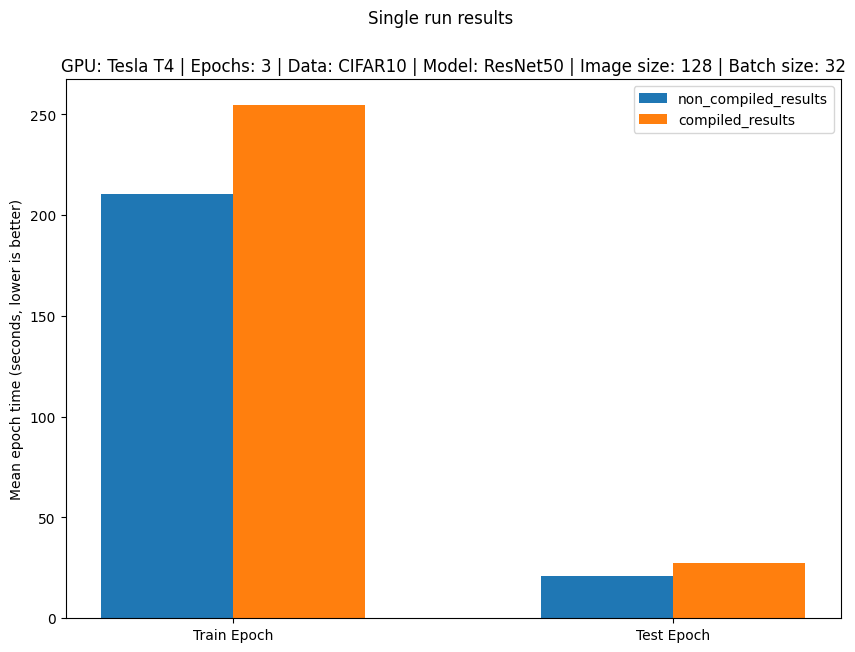

In [30]:
# Create directory for saving figures
import os
save_dir = "pytorch_2_results/figures/"
os.makedirs(save_dir, exist_ok=True)

save_path_single_run = f"{save_dir}single_run_{GPU_NAME}_{MODEL_NAME}_{DATASET_NAME}_{IMAGE_SIZE}_train_epoch_time.png"
print(f"[INFO] Saving figure to {save_path_single_run}")

plot_mean_epoch_times(non_compiled_results=single_run_no_compile_results_df,
                      compiled_results=single_run_compile_results_df,
                      multi_runs=False,
                      save_path=save_path_single_run,
                      save=True)

### 3.4 Save Single Run Results

In [31]:
# Make a directory for single_run results
import os
pytorch_2_results_dir = "pytorch_2_results"
pytorch_2_single_run_results_dir = f"{pytorch_2_results_dir}/single_run_results"
os.makedirs(pytorch_2_single_run_results_dir, exist_ok=True)

# Create filenames for each of the dataframes
save_name_for_non_compiled_results = f"single_run_non_compiled_results_{DATASET_NAME}_{MODEL_NAME}_{GPU_NAME}.csv"
save_name_for_compiled_results = f"single_run_compiled_results_{DATASET_NAME}_{MODEL_NAME}_{GPU_NAME}.csv"

# Create filepaths to save the results to
single_run_no_compile_save_path = f"{pytorch_2_single_run_results_dir}/{save_name_for_non_compiled_results}"
single_run_compile_save_path = f"{pytorch_2_single_run_results_dir}/{save_name_for_compiled_results}"
print(f"[INFO] Saving non-compiled experiment 1 results to: {single_run_no_compile_save_path}")
print(f"[INFO] Saving compiled experiment 2 results to: {single_run_compile_save_path}")

# Save the results
single_run_no_compile_results_df.to_csv(single_run_no_compile_save_path)
single_run_compile_results_df.to_csv(single_run_compile_save_path)

[INFO] Saving non-compiled experiment 1 results to: pytorch_2_results/single_run_results/single_run_non_compiled_results_CIFAR10_ResNet50_Tesla_T4.csv
[INFO] Saving compiled experiment 2 results to: pytorch_2_results/single_run_results/single_run_compiled_results_CIFAR10_ResNet50_Tesla_T4.csv


## 4. Time Models Across Multiple Runs

* Experiment 3 - 3x3 epochs without `torch.compile()`
* Experiment 4 - 3x3 epochs with `torch.compile()`

In [32]:
def create_and_train_non_compiled_model(epochs=NUM_EPOCHS,
                                        lr=LR,
                                        disable_progress_bar=False):
  """
  Create and train a non-compiled model and return the results.
  """

  model, _ = create_model()
  model.to(device)

  loss_fn = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(params=model.parameters(),
                               lr=lr)

  results = train(model=model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader,
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=epochs,
                  disable_progress_bar=disable_progress_bar,
                  device=device)

  return results

def create_compiled_model():
  """
  Create a compiled model and return it.
  """
  model, _ = create_model()
  model.to(device)

  compile_start_time = time.time()
  compiled_model = torch.compile(model) # the new magic command
  compile_end_time = time.time()
  compile_time = compile_end_time - compile_start_time
  print(f"[INFO] Model compiled in {compile_time:.6f} seconds")

  return compiled_model

def train_compiled_model(model=compiled_model,
                         epochs=NUM_EPOCHS,
                         lr=LR,
                         disable_progress_bar=False):
  """
  Train a compiled model and return the results.
  """
  loss_fn = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(params=model.parameters(),
                               lr=lr)

  compile_results = train(model=model,
                          train_dataloader=train_dataloader,
                          test_dataloader=test_dataloader,
                          optimizer=optimizer,
                          loss_fn=loss_fn,
                          epochs=epochs,
                          device=device,
                          disable_progress_bar=disable_progress_bar)

  return compile_results

### 4.1 Experiment 3 - Multiple Runs, No Compile

In [33]:
NUM_RUNS = 3
NUM_EPOCHS = 3

non_compiled_results_multiruns = []

for i in tqdm(range(NUM_RUNS)):
  print(f"[INFO] Run {i+1} of {NUM_RUNS} for a non-compiled model.")
  non_compiled_results_multiruns.append(create_and_train_non_compiled_model(epochs=NUM_EPOCHS,
                                                                            lr=LR,
                                                                            disable_progress_bar=True))

  0%|          | 0/3 [00:00<?, ?it/s]

[INFO] Run 1 of 3 for a non-compiled model.
Epoch: 1 | train_loss: 1.0836 | train_acc: 0.6175 | test_loss: 0.7717 | test_acc: 0.7335 | train_epoch_time: 205.0316 | test_epoch_time: 20.4511
Epoch: 2 | train_loss: 0.6577 | train_acc: 0.7734 | test_loss: 0.5731 | test_acc: 0.7980 | train_epoch_time: 204.7076 | test_epoch_time: 20.2687
Epoch: 3 | train_loss: 0.5065 | train_acc: 0.8245 | test_loss: 0.5930 | test_acc: 0.8010 | train_epoch_time: 204.5263 | test_epoch_time: 20.1832
[INFO] Run 2 of 3 for a non-compiled model.
Epoch: 1 | train_loss: 1.1790 | train_acc: 0.5792 | test_loss: 0.9583 | test_acc: 0.6668 | train_epoch_time: 204.9656 | test_epoch_time: 20.3005
Epoch: 2 | train_loss: 0.7320 | train_acc: 0.7464 | test_loss: 0.7022 | test_acc: 0.7658 | train_epoch_time: 205.7096 | test_epoch_time: 20.2108
Epoch: 3 | train_loss: 0.5495 | train_acc: 0.8087 | test_loss: 0.5824 | test_acc: 0.7991 | train_epoch_time: 205.9875 | test_epoch_time: 19.7208
[INFO] Run 3 of 3 for a non-compiled model

In [36]:
non_compiled_results_dfs = []
for result in non_compiled_results_multiruns:
  result_df = pd.DataFrame(result)
  non_compiled_results_dfs.append(result_df)
non_compiled_results_multiruns_df = pd.concat(non_compiled_results_dfs)

non_compiled_results_multiruns_df = non_compiled_results_multiruns_df.groupby(non_compiled_results_multiruns_df.index).mean()
non_compiled_results_multiruns_df

,train_loss,train_acc,test_loss,test_acc,train_epoch_time,test_epoch_time
0,1.153028,0.589571,0.854906,0.700812,205.129955,20.163384
1,0.704498,0.755705,0.649958,0.778088,205.406272,20.185586
2,0.537402,0.814119,0.578545,0.802782,206.169174,20.199820


### 4.2 Experiment 4 - Multiple Runs with `compile`

In [38]:
compiled_model = create_compiled_model()

compiled_results_multiruns = []

for i in tqdm(range(NUM_RUNS)):
  print(f"[INFO] Run {i+1} of {NUM_RUNS} for a compiled model.")
  results = train_compiled_model(model=compiled_model,
                                 epochs=NUM_EPOCHS,
                                 disable_progress_bar=False)
  compiled_results_multiruns.append(results)

[INFO] Model compiled in 0.015285 seconds


  0%|          | 0/3 [00:00<?, ?it/s]

[INFO] Run 1 of 3 for a compiled model.


  0%|          | 0/3 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1264 | train_acc: 0.5986 | test_loss: 0.8842 | test_acc: 0.6866 | train_epoch_time: 201.0571 | test_epoch_time: 20.1323


Training Epoch 1:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.6821 | train_acc: 0.7624 | test_loss: 0.6723 | test_acc: 0.7663 | train_epoch_time: 201.1213 | test_epoch_time: 20.2089


Training Epoch 2:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.5297 | train_acc: 0.8168 | test_loss: 0.5385 | test_acc: 0.8160 | train_epoch_time: 199.9930 | test_epoch_time: 19.6037
[INFO] Run 2 of 3 for a compiled model.


  0%|          | 0/3 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4446 | train_acc: 0.8458 | test_loss: 0.5405 | test_acc: 0.8190 | train_epoch_time: 199.8498 | test_epoch_time: 19.9507


Training Epoch 1:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.3354 | train_acc: 0.8855 | test_loss: 0.4745 | test_acc: 0.8431 | train_epoch_time: 200.0621 | test_epoch_time: 19.8235


Training Epoch 2:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.2536 | train_acc: 0.9098 | test_loss: 0.4770 | test_acc: 0.8452 | train_epoch_time: 200.6836 | test_epoch_time: 20.3123
[INFO] Run 3 of 3 for a compiled model.


  0%|          | 0/3 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2089 | train_acc: 0.9268 | test_loss: 0.4792 | test_acc: 0.8532 | train_epoch_time: 199.2122 | test_epoch_time: 19.3223


Training Epoch 1:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.1408 | train_acc: 0.9508 | test_loss: 0.5268 | test_acc: 0.8549 | train_epoch_time: 199.4555 | test_epoch_time: 20.1605


Training Epoch 2:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.1171 | train_acc: 0.9594 | test_loss: 0.5499 | test_acc: 0.8471 | train_epoch_time: 198.4700 | test_epoch_time: 19.7975


In [46]:
compiled_results_df = []
for result in compiled_results_multiruns:
  result_df = pd.DataFrame(result)
  compiled_results_df.append(result_df)
compiled_results_multiruns_df = pd.concat(compiled_results_df)

compiled_results_multiruns_df = compiled_results_multiruns_df.groupby(compiled_results_multiruns_df.index).mean()
compiled_results_multiruns_df

,train_loss,train_acc,test_loss,test_acc,train_epoch_time,test_epoch_time
0,0.593294,0.790387,0.634618,0.786275,200.039704,19.801782
1,0.386091,0.866256,0.557874,0.821419,200.212940,20.064289
2,0.300133,0.895360,0.521796,0.836129,199.715506,19.904522


### 4.3 Compare Results

Mean train epoch time difference: -2.714% (negative means faster)
Mean test epoch time difference: -1.285% (negative means faster)
[INFO] Plot saved to pytorch_2_results/figures/multi_run_Tesla_T4_ResNet50_CIFAR10_128_train_epoch_time.png


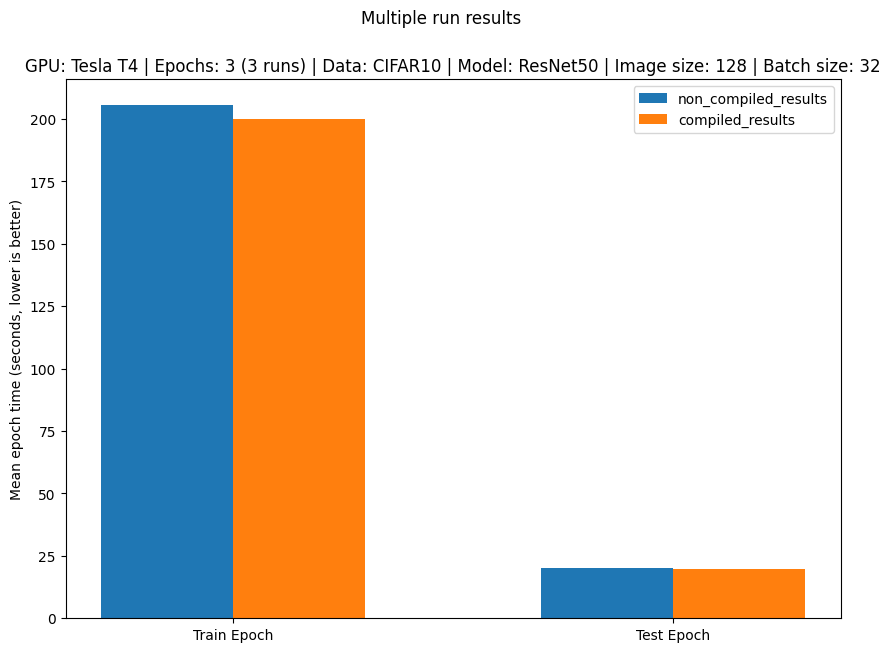

In [49]:
# Create a directory to save the multi-run figure to
os.makedirs("pytorch_2_results/figures", exist_ok=True)

# Create a path to save the figure for multiple runs
save_path_multi_run = f"pytorch_2_results/figures/multi_run_{GPU_NAME}_{MODEL_NAME}_{DATASET_NAME}_{IMAGE_SIZE}_train_epoch_time.png"

# Plot the mean epoch times for experiment 3 and 4
plot_mean_epoch_times(non_compiled_results=non_compiled_results_multiruns_df,
                      compiled_results=compiled_results_multiruns_df,
                      multi_runs=True,
                      num_runs=NUM_RUNS,
                      save_path=save_path_multi_run,
                      save=True)

### 4.4 Save to File

In [50]:
# Make a directory for multi_run results
import os
pytorch_2_results_dir = "pytorch_2_results"
pytorch_2_multi_run_results_dir = f"{pytorch_2_results_dir}/multi_run_results"
os.makedirs(pytorch_2_multi_run_results_dir, exist_ok=True)

# Create filenames for each of the dataframes
save_name_for_multi_run_non_compiled_results = f"multi_run_non_compiled_results_{NUM_RUNS}_runs_{DATASET_NAME}_{MODEL_NAME}_{GPU_NAME}.csv"
save_name_for_multi_run_compiled_results = f"multi_run_compiled_results_{NUM_RUNS}_runs_{DATASET_NAME}_{MODEL_NAME}_{GPU_NAME}.csv"

# Create filepaths to save the results to
multi_run_no_compile_save_path = f"{pytorch_2_multi_run_results_dir}/{save_name_for_non_compiled_results}"
multi_run_compile_save_path = f"{pytorch_2_multi_run_results_dir}/{save_name_for_compiled_results}"
print(f"[INFO] Saving experiment 3 non-compiled results to: {multi_run_no_compile_save_path}")
print(f"[INFO] Saving experiment 4 compiled results to: {multi_run_compile_save_path}")

# Save the results
non_compiled_results_multiruns_df.to_csv(multi_run_no_compile_save_path)
compiled_results_multiruns_df.to_csv(multi_run_compile_save_path)

[INFO] Saving experiment 3 non-compiled results to: pytorch_2_results/multi_run_results/single_run_non_compiled_results_CIFAR10_ResNet50_Tesla_T4.csv
[INFO] Saving experiment 4 compiled results to: pytorch_2_results/multi_run_results/single_run_compiled_results_CIFAR10_ResNet50_Tesla_T4.csv
